# 🚗 UK Road Accidents Geospatial Risk Prediction Model

## Machine Learning Pipeline for Insurance Risk Assessment (1979-2024) (Update)

**Author:** Tahsine Kajola SALAMI  
**Date:** January 2026(Update)

**Objective:** Develop a predictive model to assess accident risk based on geospatial, temporal, and environmental factors.

### 📋 Project Overview
- **Dataset:** UK Department for Transport Road Safety Data (45 years)
- **Records:** 2M+ accidents with 3 linked tables
- **Goal:** Predict accident severity and create risk scoring map
- **Business Application:** Insurance premium calculation & risk zone identification

### 🎯 Key Deliverables
1. Clean, engineered dataset with 50+ features
2. Multi-class classification model (Slight/Serious/Fatal)
3. Feature importance analysis
4. Geospatial risk grid for interactive map visualization
5. Model exportation for production deployment

### ⚠️ Important Note
**Data is CODED with numeric values** - we'll decode them using UK DfT standard mappings

## 📦 1. Environment Setup & Library Imports

In [1]:
# Core data manipulation
import pandas as pd
import numpy as np
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# Machine Learning
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    accuracy_score, f1_score, roc_auc_score,
    precision_recall_fscore_support
)

# ML Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Model persistence
import joblib
import json

# Set plot style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ All libraries imported successfully")
print(f"📅 Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M')}")

✅ All libraries imported successfully
📅 Analysis Date: 2026-01-18 15:52


## 🗂️ 2. UK DfT Code Mappings (Standard Codes)
 
Based on UK Department for Transport STATS19 coding system.

**Source:** Road Safety Open Dataset Data Guide 2024

In [18]:
# Create mapping dictionaries for decoding

# Collision Severity (most important!)
SEVERITY_MAP = {
    1: 'Fatal',
    2: 'Serious', 
    3: 'Slight'
}

# Weather Conditions (commonly used codes)
WEATHER_MAP = {
    1: 'Fine no high winds',
    2: 'Raining no high winds',
    3: 'Snowing no high winds',
    4: 'Fine + high winds',
    5: 'Raining + high winds',
    6: 'Snowing + high winds',
    7: 'Fog or mist',
    8: 'Other',
    9: 'Unknown',
    -1: 'Data missing or out of range'
}

# Light Conditions
LIGHT_MAP = {
    1: 'Daylight',
    4: 'Darkness - lights lit',
    5: 'Darkness - lights unlit',
    6: 'Darkness - no lighting',
    7: 'Darkness - lighting unknown',
    -1: 'Data missing or out of range'
}

# Road Surface Conditions
ROAD_SURFACE_MAP = {
    1: 'Dry',
    2: 'Wet or damp',
    3: 'Snow',
    4: 'Frost or ice',
    5: 'Flood over 3cm',
    6: 'Oil or diesel',
    7: 'Mud',
    -1: 'Data missing or out of range'
}

# Urban or Rural
URBAN_RURAL_MAP = {
    1: 'Urban',
    2: 'Rural',
    3: 'Unallocated',
    -1: 'Data missing or out of range'
}

# Sex (for casualties and drivers)
SEX_MAP = {
    1: 'Male',
    2: 'Female',
    3: 'Not known',
    -1: 'Data missing or out of range'
}

# Casualty Class
CASUALTY_CLASS_MAP = {
    1: 'Driver or rider',
    2: 'Passenger',
    3: 'Pedestrian'
}

# Vehicle Type (common codes)
VEHICLE_TYPE_MAP = {
    1: 'Pedal cycle',
    2: 'Motorcycle 50cc and under',
    3: 'Motorcycle 125cc and under',
    4: 'Motorcycle over 125cc and up to 500cc',
    5: 'Motorcycle over 500cc',
    8: 'Taxi/Private hire car',
    9: 'Car',
    10: 'Minibus',
    11: 'Bus or coach',
    16: 'Ridden horse',
    17: 'Agricultural vehicle',
    18: 'Tram',
    19: 'Van / Goods 3.5 tonnes mgw or under',
    20: 'Goods over 3.5t. and under 7.5t',
    21: 'Goods 7.5 tonnes mgw and over',
    22: 'Mobility scooter',
    23: 'Electric motorcycle',
    90: 'Other vehicle',
    97: 'Motorcycle - unknown cc',
    98: 'Goods vehicle - unknown weight',
    99: 'Unknown vehicle type (self rep only)',
    103: 'Motorcycle - Scooter (1979-1998)',
    104: 'Motorcycle (1979-1998)',
    105: 'Motorcycle - Combination (1979-1998)',
    106: 'Motorcycle over 125cc (1999-2004)',
    108: 'Taxi (excluding private hire cars) (1979-2004)',
    109: 'Car (including private hire cars) (1979-2004)',
    110: 'Minibus/Motor caravan (1979-1998)',
    113: 'Goods over 3.5 tonnes (1979-1998)',
    -1: 'Data missing',
}

print("✅ Code mappings defined")
print(f"   • Severity: {len(SEVERITY_MAP)} codes")
print(f"   • Weather: {len(WEATHER_MAP)} codes")
print(f"   • Light: {len(LIGHT_MAP)} codes")

✅ Code mappings defined
   • Severity: 3 codes
   • Weather: 10 codes
   • Light: 6 codes


## 📊 3. Data Loading & Initial Exploration

### Strategy: Memory-Efficient Loading
- Filter to recent years (2018-2024) to reduce dataset size
- Use optimized dtypes (category for strings)
- Load only essential columns
- Target: ~500k-1M records instead of 2M+

### ⚠️ Important: Nullable Integer Types
We use **Int8, Int16, Int32** (capital I) instead of int8/int16/int32 because:
- Regular int types (`int8`) **cannot** contain NaN/missing values
- Nullable int types (`Int8`) **can** contain NaN values
- This prevents errors when loading data with missing values

In [2]:
# Define file paths
COLLISION_PATH = "./data/dft-road-casualty-statistics-collision-1979-latest-published-year.csv"
CASUALTY_PATH = "./data/dft-road-casualty-statistics-casualty-1979-latest-published-year.csv"
VEHICLE_PATH = "./data/dft-road-casualty-statistics-vehicle-1979-latest-published-year.csv"

In [19]:
# Filter year (focus on recent data - 2018 to 2024)
YEAR_FILTER = 2018

print(f"🎯 Filtering data from {YEAR_FILTER} onwards...")

🎯 Filtering data from 2018 onwards...


In [22]:
# Load COLLISION table (main table)
print("📥 Loading COLLISION data...")

# Use Nullable integer types (Int8, Int16, Int32 with capital I) to handle NaN values
collision = pd.read_csv(
    COLLISION_PATH,
    parse_dates=['date'],
    dtype={
        'collision_index': 'str',
        'collision_year': 'Int32',      # Nullable integer
        'collision_severity': 'Int8',   # Nullable integer
        'weather_conditions': 'Int8',
        'light_conditions': 'Int8',
        'road_surface_conditions': 'Int8',
        'urban_or_rural_area': 'Int8',
        'speed_limit': 'Int16'
    },
    usecols=[
        'collision_index', 'collision_year', 'latitude', 'longitude',
        'date', 'day_of_week', 'time', 'collision_severity',
        'number_of_casualties', 'number_of_vehicles', 
        'weather_conditions', 'light_conditions', 
        'road_surface_conditions', 'urban_or_rural_area',
        'speed_limit', 'road_type', 'junction_detail'
    ]
)

# Filter by year
collision = collision[collision['collision_year'] >= YEAR_FILTER].copy()
print(f"✅ Collision data loaded: {collision.shape[0]:,} records, {collision.shape[1]} columns")
print(f"📊 Memory usage: {collision.memory_usage(deep=True).sum() / 1e6:.2f} MB")
print(f"📅 Date range: {collision['date'].min()} to {collision['date'].max()}")

📥 Loading COLLISION data...
✅ Collision data loaded: 743,646 records, 17 columns
📊 Memory usage: 153.19 MB
📅 Date range: 2018-01-01 00:00:00 to 2024-12-31 00:00:00


In [23]:
# Load CASUALTIES table
print("\n📥 Loading CASUALTIES data...")

casualties = pd.read_csv(
    CASUALTY_PATH,
    dtype={
        'collision_index': 'str',
        'collision_year': 'Int32',      # Nullable integer
        'casualty_severity': 'Int8',
        'casualty_class': 'Int8',
        'sex_of_casualty': 'Int8',
        'age_of_casualty': 'Int16'
    },
    usecols=[
        'collision_index', 'collision_year', 'casualty_severity',
        'age_of_casualty', 'casualty_class', 'sex_of_casualty'
    ]
)

casualties = casualties[casualties['collision_year'] >= YEAR_FILTER].copy()

print(f"✅ Casualties data loaded: {casualties.shape[0]:,} records")


📥 Loading CASUALTIES data...
✅ Casualties data loaded: 954,277 records


In [24]:
# Load VEHICLES table
print("\n📥 Loading VEHICLES data...")

vehicles = pd.read_csv(
    VEHICLE_PATH,
    dtype={
        'collision_index': 'str',
        'collision_year': 'Int32',      # Nullable integer
        'vehicle_type': 'Int8',
        'sex_of_driver': 'Int8',
        'age_of_vehicle': 'Int16',
        'age_of_driver': 'Int16'
    },
    usecols=[
        'collision_index', 'collision_year', 'vehicle_type',
        'age_of_vehicle', 'age_of_driver', 'sex_of_driver'
    ]
)

vehicles = vehicles[vehicles['collision_year'] >= YEAR_FILTER].copy()

print(f"✅ Vehicles data loaded: {vehicles.shape[0]:,} records")


📥 Loading VEHICLES data...
✅ Vehicles data loaded: 1,363,482 records


In [25]:
# Check for missing values in loaded data
print("\n" + "="*60)
print("🔍 CHECKING FOR MISSING VALUES AFTER LOADING")
print("="*60)

print("\n📊 COLLISION missing values:")
collision_missing = collision.isnull().sum()
collision_missing = collision_missing[collision_missing > 0].sort_values(ascending=False)
if len(collision_missing) > 0:
    for col, count in collision_missing.items():
        pct = (count / len(collision) * 100)
        print(f"   • {col}: {count:,} ({pct:.2f}%)")
else:
    print("   ✅ No missing values!")

print("\n👥 CASUALTIES missing values:")
casualties_missing = casualties.isnull().sum()
casualties_missing = casualties_missing[casualties_missing > 0].sort_values(ascending=False)
if len(casualties_missing) > 0:
    for col, count in casualties_missing.items():
        pct = (count / len(casualties) * 100)
        print(f"   • {col}: {count:,} ({pct:.2f}%)")
else:
    print("   ✅ No missing values!")

print("\n🚗 VEHICLES missing values:")
vehicles_missing = vehicles.isnull().sum()
vehicles_missing = vehicles_missing[vehicles_missing > 0].sort_values(ascending=False)
if len(vehicles_missing) > 0:
    for col, count in vehicles_missing.items():
        pct = (count / len(vehicles) * 100)
        print(f"   • {col}: {count:,} ({pct:.2f}%)")
else:
    print("   ✅ No missing values!")

print("\n💡 TIP: Nullable Int types (Int8, Int16, Int32) allow us to keep NaN values without conversion errors")


🔍 CHECKING FOR MISSING VALUES AFTER LOADING

📊 COLLISION missing values:
   • longitude: 148 (0.02%)
   • latitude: 148 (0.02%)

👥 CASUALTIES missing values:
   ✅ No missing values!

🚗 VEHICLES missing values:
   ✅ No missing values!

💡 TIP: Nullable Int types (Int8, Int16, Int32) allow us to keep NaN values without conversion errors


In [26]:
# Verify the codes in YOUR data
print("\n" + "="*60)
print("🔍 VERIFYING CODES IN YOUR DATA")
print("="*60)

print("\n📊 Collision Severity values found:")
print(collision['collision_severity'].value_counts().sort_index())
for code, label in SEVERITY_MAP.items():
    count = (collision['collision_severity'] == code).sum()
    if count > 0:
        print(f"   {code} = {label}: {count:,} ({count/len(collision)*100:.1f}%)")

print("\n🌦️  Weather Conditions values found:")
weather_counts = collision['weather_conditions'].value_counts().sort_index()
print(weather_counts.head(10))

print("\n💡 Light Conditions values found:")
light_counts = collision['light_conditions'].value_counts().sort_index()
print(light_counts)

print("\n🛣️  Road Surface Conditions values found:")
surface_counts = collision['road_surface_conditions'].value_counts().sort_index()
print(surface_counts)


🔍 VERIFYING CODES IN YOUR DATA

📊 Collision Severity values found:
collision_severity
1     10820
2    155925
3    576901
Name: count, dtype: Int64
   1 = Fatal: 10,820 (1.5%)
   2 = Serious: 155,925 (21.0%)
   3 = Slight: 576,901 (77.6%)

🌦️  Weather Conditions values found:
weather_conditions
-1        32
1     592493
2      85270
3       3169
4       7522
5       8665
6        734
7       3139
8      20916
9      21706
Name: count, dtype: Int64

💡 Light Conditions values found:
light_conditions
-1        20
1     531783
4     153308
5       5419
6      38803
7      14313
Name: count, dtype: Int64

🛣️  Road Surface Conditions values found:
road_surface_conditions
-1      3696
1     534154
2     184974
3       2605
4       8773
5       1133
9       8311
Name: count, dtype: Int64


In [15]:
print(collision.head())
print("==============")
print(casualties.head())
print("==============")
print(vehicles.head())
print("==============")

   collision_index  collision_year  longitude   latitude collision_severity  \
0    2018450290294            2018  -0.746206  51.088970                  3   
1    2020230984311            2020  -1.511123  52.221299                  2   
5    2019010177739            2019  -0.029082  51.470486                  3   
15   2022991145836            2022  -4.345775  55.822102                  3   
18   2019470863182            2019   0.474832  50.980520                  2   

    number_of_vehicles  number_of_casualties       date  day_of_week   time  \
0                    2                     2 2018-04-15            1  08:00   
1                    5                     2 2020-09-21            2  23:00   
5                    2                     1 2019-04-29            2  09:01   
15                   1                     1 2022-02-21            2  16:40   
18                   2                     1 2019-07-30            3  08:01   

    ... light_conditions  weather_conditions  road

## 🧹 4. Data Cleaning & Preprocessing

In [27]:
print("🧹 Starting data cleaning process...")

# Remove records without GPS coordinates
initial_rows = collision.shape[0]
collision = collision.dropna(subset=['latitude', 'longitude'])
removed_coords = initial_rows - collision.shape[0]

print(f"❌ Removed {removed_coords:,} records without GPS coordinates ({removed_coords/initial_rows*100:.2f}%)")

🧹 Starting data cleaning process...
❌ Removed 148 records without GPS coordinates (0.02%)


In [28]:
# Filter GPS coordinates to UK boundaries
# UK bounds: latitude 49-61°N, longitude -8 to 2°E
# NOTE: The boundaries are already correct, but, we're doing it for precaution
print("\n🗺️  Filtering to UK geographic boundaries...")

uk_bounds = collision[
    (collision['latitude'].between(49, 61)) &
    (collision['longitude'].between(-8, 2))
]

removed_bounds = collision.shape[0] - uk_bounds.shape[0]
collision = uk_bounds.copy()

print(f"❌ Removed {removed_bounds:,} records outside UK bounds")


🗺️  Filtering to UK geographic boundaries...
❌ Removed 0 records outside UK bounds


In [29]:
# Extract temporal features from 'time' column
print("\n⏰ Extracting temporal features...")

collision['hour'] = pd.to_datetime(
    collision['time'], 
    format='%H:%M', 
    errors='coerce'
).dt.hour

# Extract from 'date' column
collision['month'] = collision['date'].dt.month
collision['year'] = collision['date'].dt.year
collision['day'] = collision['date'].dt.day
collision['day_of_year'] = collision['date'].dt.dayofyear
collision['week_of_year'] = collision['date'].dt.isocalendar().week

print("✅ Temporal features extracted")


⏰ Extracting temporal features...
✅ Temporal features extracted


In [30]:
# Handle missing values (replace -1 and NaN with mode/median)
print("\n🔧 Handling missing values...")

# For coded columns, replace -1 with mode
coded_cols = ['weather_conditions', 'light_conditions', 'road_surface_conditions']
for col in coded_cols:
    # Replace -1 with NaN first
    collision[col] = collision[col].replace(-1, np.nan)
    # Fill with mode
    if collision[col].isnull().sum() > 0:
        mode_value = collision[col].mode()[0]
        collision[col].fillna(mode_value, inplace=True)
        print(f"  • {col}: filled {collision[col].isnull().sum()} values with mode ({mode_value})")

# Numeric columns
if collision['hour'].isnull().sum() > 0:
    median_hour = collision['hour'].median()
    collision['hour'].fillna(median_hour, inplace=True)
    print(f"  • hour: filled with median ({median_hour})")

if collision['speed_limit'].isnull().sum() > 0:
    median_speed = collision['speed_limit'].median()
    collision['speed_limit'].fillna(median_speed, inplace=True)
    print(f"  • speed_limit: filled with median ({median_speed})")


🔧 Handling missing values...
  • weather_conditions: filled 0 values with mode (1)
  • light_conditions: filled 0 values with mode (1)
  • road_surface_conditions: filled 0 values with mode (1)


In [31]:
# Remove duplicates
print("\n🔄 Checking for duplicates...")
duplicates = collision.duplicated(subset='collision_index').sum()
if duplicates > 0:
    collision = collision.drop_duplicates(subset='collision_index')
    print(f"❌ Removed {duplicates:,} duplicate records")
else:
    print("✅ No duplicates found")

print(f"\n✅ Cleaning complete! Final dataset: {collision.shape[0]:,} records")


🔄 Checking for duplicates...
✅ No duplicates found

✅ Cleaning complete! Final dataset: 743,498 records


## 🔗 5. Data Aggregation - Joining Tables

In [32]:
print("🔗 Aggregating CASUALTIES data by collision...")

casualties_agg = casualties.groupby('collision_index').agg({
    'casualty_severity': lambda x: (x == 1).sum(),  # Fatal count (code 1 = Fatal)
    'age_of_casualty': 'mean',
    'casualty_class': lambda x: (x == 3).sum(),  # Pedestrian count (code 3 = Pedestrian)
    'sex_of_casualty': 'count'  # Total casualties
}).rename(columns={
    'casualty_severity': 'fatal_count',
    'age_of_casualty': 'avg_casualty_age',
    'casualty_class': 'pedestrian_count',
    'sex_of_casualty': 'total_casualties_check'
})

print(f"✅ Casualties aggregated: {casualties_agg.shape[0]:,} unique accidents")

🔗 Aggregating CASUALTIES data by collision...
✅ Casualties aggregated: 743,646 unique accidents


In [33]:
print("\n🔗 Aggregating VEHICLES data by collision...")

vehicles_agg = vehicles.groupby('collision_index').agg({
    'vehicle_type': lambda x: x.mode()[0] if len(x) > 0 else 9,  # Default to Car (9)
    'age_of_vehicle': 'mean',
    'age_of_driver': 'mean',
    'sex_of_driver': lambda x: (x == 1).sum() / len(x) if len(x) > 0 else 0.5,  # % Male
    'collision_year': 'count'
}).rename(columns={
    'vehicle_type': 'dominant_vehicle_type',
    'age_of_vehicle': 'avg_vehicle_age',
    'age_of_driver': 'avg_driver_age',
    'sex_of_driver': 'male_driver_ratio',
    'collision_year': 'vehicle_count_check'
})

print(f"✅ Vehicles aggregated: {vehicles_agg.shape[0]:,} unique accidents")


🔗 Aggregating VEHICLES data by collision...
✅ Vehicles aggregated: 743,646 unique accidents


In [34]:
print("\n🔗 Joining all tables...")

df = collision.merge(casualties_agg, on='collision_index', how='left')
print(f"  • After casualties join: {df.shape}")

df = df.merge(vehicles_agg, on='collision_index', how='left')
print(f"  • After vehicles join: {df.shape}")

# %%
# Fill NaN from joins
print("\n🔧 Handling missing values from joins...")

fill_values = {
    'fatal_count': 0,
    'pedestrian_count': 0,
    'avg_casualty_age': df['avg_casualty_age'].median(),
    'avg_vehicle_age': df['avg_vehicle_age'].median(),
    'avg_driver_age': df['avg_driver_age'].median(),
    'male_driver_ratio': 0.5
}

for col, val in fill_values.items():
    df[col].fillna(val, inplace=True)

print(f"✅ Final joined dataset: {df.shape[0]:,} records, {df.shape[1]} columns")


🔗 Joining all tables...
  • After casualties join: (743498, 27)
  • After vehicles join: (743498, 32)

🔧 Handling missing values from joins...
✅ Final joined dataset: 743,498 records, 32 columns


In [35]:
df.head()

,collision_index,collision_year,longitude,latitude,collision_severity,number_of_vehicles,number_of_casualties,date,day_of_week,time,...,week_of_year,fatal_count,avg_casualty_age,pedestrian_count,total_casualties_check,dominant_vehicle_type,avg_vehicle_age,avg_driver_age,male_driver_ratio,vehicle_count_check
0,2018450290294,2018,-0.746206,51.088970,3,2,2,2018-04-15,1,08:00,...,15,0,37.0,0,2,9,5.5,37.0,0.0,2
1,2020230984311,2020,-1.511123,52.221299,2,5,2,2020-09-21,2,23:00,...,39,0,42.0,0,2,21,6.4,49.2,1.0,5
2,2019010177739,2019,-0.029082,51.470486,3,2,1,2019-04-29,2,09:01,...,18,0,48.0,0,1,5,7.5,46.0,1.0,2
3,2022991145836,2022,-4.345775,55.822102,3,1,1,2022-02-21,2,16:40,...,8,0,0.0,1,1,9,3.0,68.0,1.0,1
4,2019470863182,2019,0.474832,50.980520,2,2,1,2019-07-30,3,08:01,...,31,0,48.0,0,1,5,11.0,52.5,1.0,2


## ⚙️ 6. Feature Engineering (Using Numeric Codes)

In [36]:
print("⚙️ Creating TEMPORAL features...")

# Rush hours
df['is_rush_hour'] = ((df['hour'] >= 7) & (df['hour'] <= 9) | 
                       (df['hour'] >= 17) & (df['hour'] <= 19)).astype(int)

# Weekend
df['is_weekend'] = (df['day_of_week'].isin([6, 7])).astype(int)

# Night time
df['is_night'] = ((df['hour'] >= 20) | (df['hour'] <= 6)).astype(int)

# Season
df['season'] = df['month'].apply(
    lambda x: 1 if x in [12,1,2] else 2 if x in [3,4,5] else 3 if x in [6,7,8] else 4
)

print("✅ Created: is_rush_hour, is_weekend, is_night, season")

⚙️ Creating TEMPORAL features...
✅ Created: is_rush_hour, is_weekend, is_night, season


In [37]:
print("\n⚙️ Creating WEATHER-related features using CODES...")

# Bad weather (codes 2,3,5,6,7 = rain/snow/fog)
df['bad_weather'] = df['weather_conditions'].isin([2, 3, 5, 6, 7]).astype(int)

# Darkness (codes 4,5,6,7 = any darkness)
df['is_dark'] = df['light_conditions'].isin([4, 5, 6, 7]).astype(int)

# Poor visibility (bad weather OR darkness)
df['poor_visibility'] = ((df['bad_weather'] == 1) | (df['is_dark'] == 1)).astype(int)

# Wet or icy road (codes 2,3,4 = wet/snow/ice)
df['wet_or_icy_road'] = df['road_surface_conditions'].isin([2, 3, 4]).astype(int)

# Dangerous combo: rain + darkness
df['rain_and_dark'] = ((df['weather_conditions'] == 2) & (df['is_dark'] == 1)).astype(int)

print("✅ Created: bad_weather, is_dark, poor_visibility, wet_or_icy_road, rain_and_dark")


⚙️ Creating WEATHER-related features using CODES...
✅ Created: bad_weather, is_dark, poor_visibility, wet_or_icy_road, rain_and_dark


In [38]:
print("\n⚙️ Creating SPATIAL features...")

# High density area (low speed limit)
df['high_density_area'] = (df['speed_limit'] <= 30).astype(int)

# Urban indicator (code 1 = Urban)
df['is_urban'] = (df['urban_or_rural_area'] == 1).astype(int)

print("✅ Created: high_density_area, is_urban")


⚙️ Creating SPATIAL features...
✅ Created: high_density_area, is_urban


In [39]:
print("\n⚙️ Creating SEVERITY-related features...")

# Casualties per vehicle
df['casualties_per_vehicle'] = df['number_of_casualties'] / df['number_of_vehicles'].replace(0, 1)

# Multi-vehicle
df['is_multi_vehicle'] = (df['number_of_vehicles'] > 1).astype(int)

# High casualty event
df['high_casualty_event'] = (df['number_of_casualties'] > 2).astype(int)

# Has fatality
df['has_fatality'] = (df['fatal_count'] > 0).astype(int)

print("✅ Created: casualties_per_vehicle, is_multi_vehicle, high_casualty_event, has_fatality")


⚙️ Creating SEVERITY-related features...
✅ Created: casualties_per_vehicle, is_multi_vehicle, high_casualty_event, has_fatality


In [40]:
print("\n" + "="*60)
print("📊 FEATURE ENGINEERING SUMMARY")
print("="*60)
print(f"✅ Dataset shape: {df.shape}")
print(f"✅ Total features created: 15+")


📊 FEATURE ENGINEERING SUMMARY
✅ Dataset shape: (743498, 47)
✅ Total features created: 15+


## 📊 7. Exploratory Data Analysis


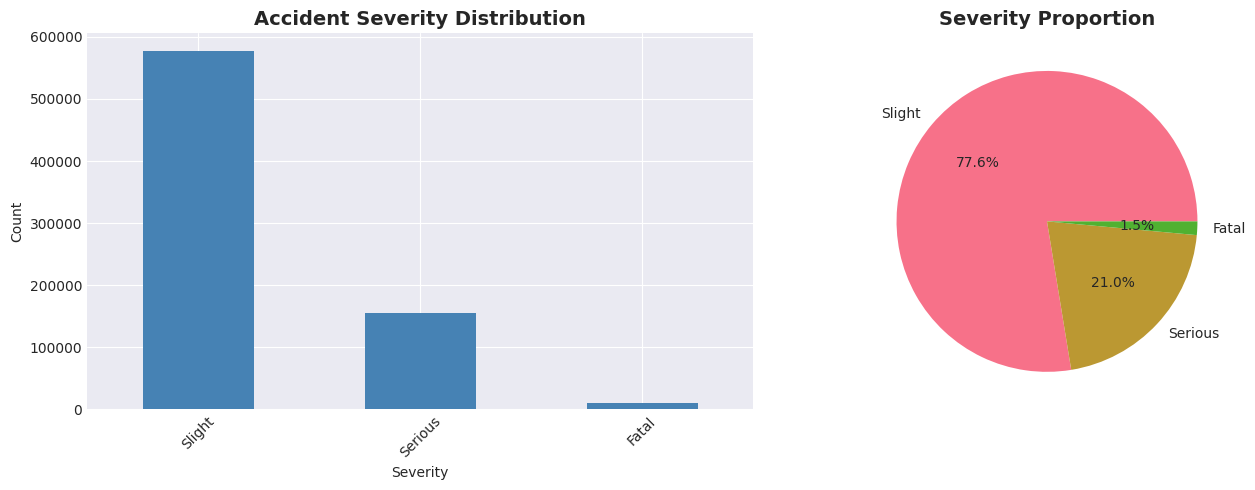

In [41]:
# Severity distribution (decode for visualization)
severity_labels = df['collision_severity'].map(SEVERITY_MAP)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

severity_labels.value_counts().plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Accident Severity Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Severity')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

severity_labels.value_counts().plot(kind='pie', ax=axes[1], autopct='%1.1f%%')
axes[1].set_title('Severity Proportion', fontsize=14, fontweight='bold')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

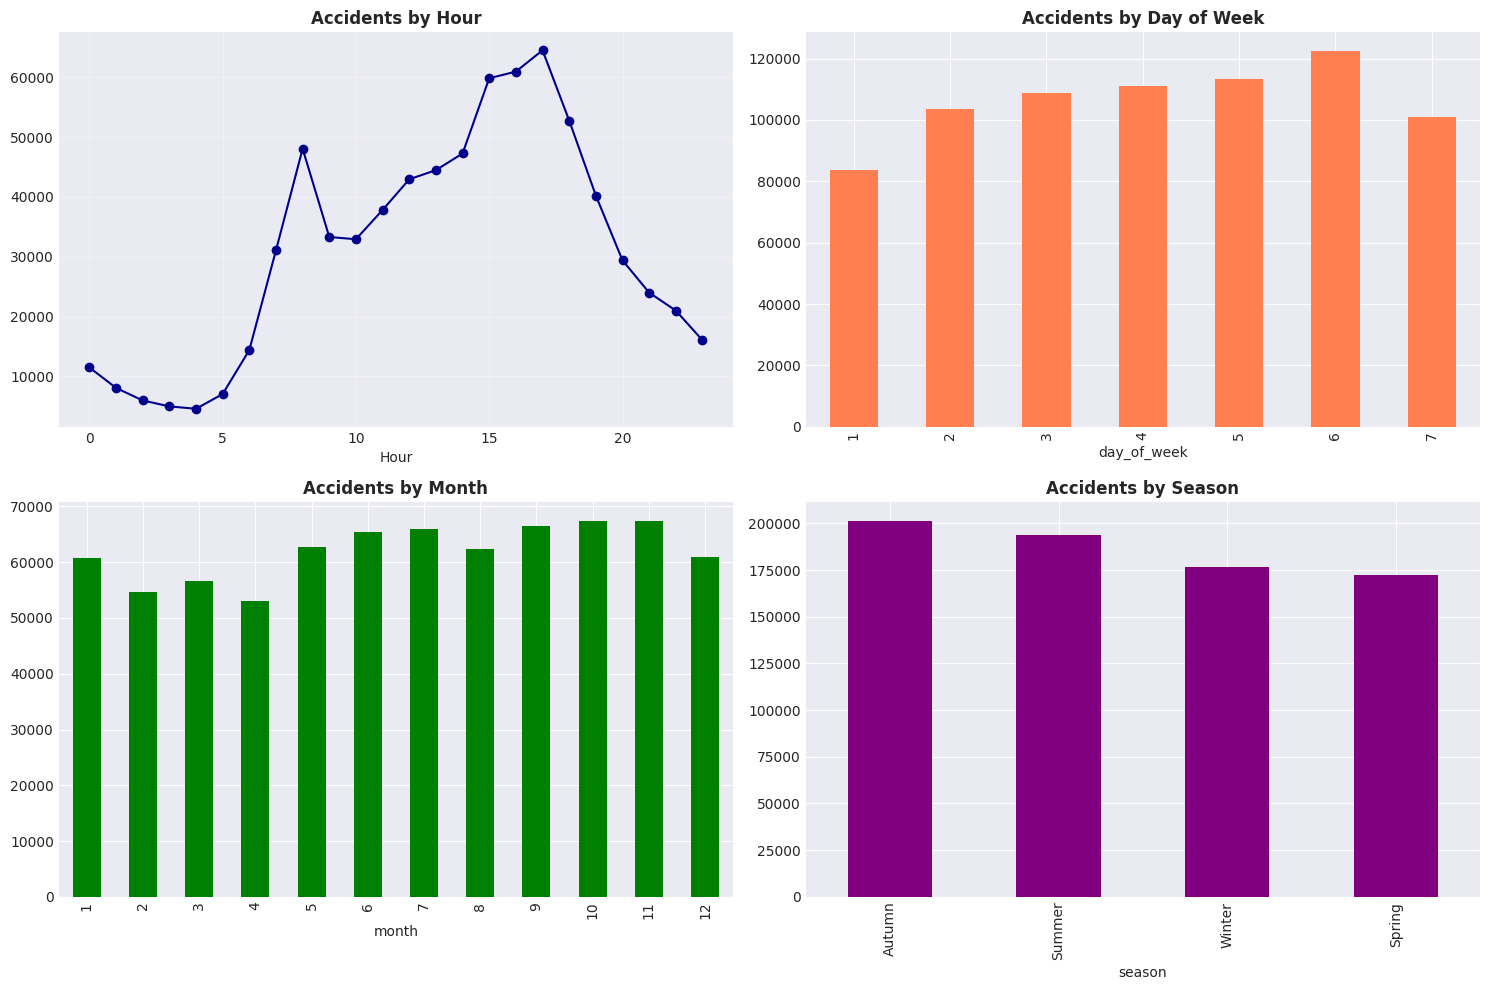

In [42]:
# Temporal patterns
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# By hour
df['hour'].value_counts().sort_index().plot(kind='line', ax=axes[0,0], marker='o', color='darkblue')
axes[0,0].set_title('Accidents by Hour', fontsize=12, fontweight='bold')
axes[0,0].set_xlabel('Hour')
axes[0,0].grid(True, alpha=0.3)

# By day of week
df['day_of_week'].value_counts().sort_index().plot(kind='bar', ax=axes[0,1], color='coral')
axes[0,1].set_title('Accidents by Day of Week', fontsize=12, fontweight='bold')

# By month
df['month'].value_counts().sort_index().plot(kind='bar', ax=axes[1,0], color='green')
axes[1,0].set_title('Accidents by Month', fontsize=12, fontweight='bold')

# By season
season_labels = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Autumn'}
df['season'].map(season_labels).value_counts().plot(kind='bar', ax=axes[1,1], color='purple')
axes[1,1].set_title('Accidents by Season', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

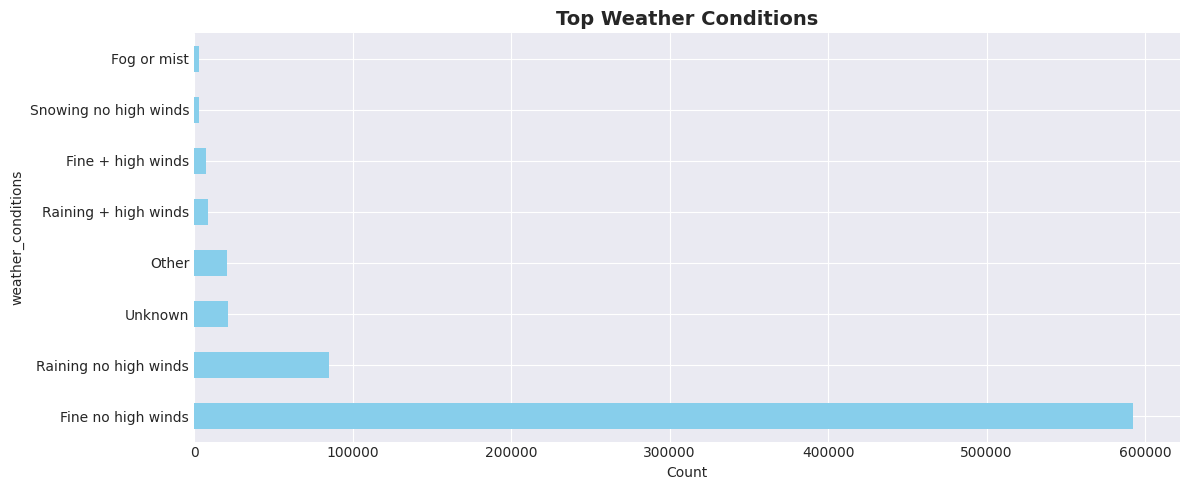

In [43]:
# Weather analysis (decoded)
weather_labels = df['weather_conditions'].map(WEATHER_MAP)

plt.figure(figsize=(12, 5))
weather_labels.value_counts().head(8).plot(kind='barh', color='skyblue')
plt.title('Top Weather Conditions', fontsize=14, fontweight='bold')
plt.xlabel('Count')
plt.tight_layout()
plt.show()

## 🎯 8. Model Preparation

### ⚠️ Important: Target Variable Encoding
**UK DfT uses codes 1-3, but ML models require 0-2:**
- **Original UK DfT codes:** 1 = Fatal, 2 = Serious, 3 = Slight
- **Encoded for ML models:** 0 = Fatal, 1 = Serious, 2 = Slight
 
We'll encode the target for training, but keep original codes for visualization/export.

In [50]:
print("🎯 Preparing features for modeling...")

# Columns to exclude
exclude_cols = [
    'collision_index', 'date', 'time', 'collision_year',
    'latitude', 'longitude', 'collision_severity',
    'day', 'day_of_year', 'week_of_year', 'road_type', 'junction_detail'
]

# Features (X) and Target (y)
feature_cols = [col for col in df.columns if col not in exclude_cols]
X = df[feature_cols].copy()

# ⚠️ IMPORTANT: Encode target to start from 0 (required by sklearn/XGBoost)
# UK DfT codes: 1=Fatal, 2=Serious, 3=Slight
# ML models need: 0=Fatal, 1=Serious, 2=Slight
y_original = df['collision_severity'].copy()
y = y_original - 1  # Simple mapping: 1→0, 2→1, 3→2

# Create reverse mapping for interpretation
severity_labels = {0: 'Fatal', 1: 'Serious', 2: 'Slight'}

# Save coordinates with ORIGINAL codes
coords_df = df[['collision_index', 'latitude', 'longitude', 'collision_severity']].copy()

print(f"✅ Features (X): {X.shape}")
print(f"✅ Target (y): {y.shape}")
print(f"\n📊 Target encoding:")
print(f"   Original UK DfT codes: {sorted(y_original.unique())}")
print(f"   Encoded for ML:        {sorted(y.unique())}")
print(f"\n📋 Class mapping:")
for code, label in severity_labels.items():
    count = (y == code).sum()
    print(f"   {code} = {label}: {count:,} ({count/len(y)*100:.1f}%)")

🎯 Preparing features for modeling...
✅ Features (X): (743498, 35)
✅ Target (y): (743498,)

📊 Target encoding:
   Original UK DfT codes: [np.int8(1), np.int8(2), np.int8(3)]
   Encoded for ML:        [np.int8(0), np.int8(1), np.int8(2)]

📋 Class mapping:
   0 = Fatal: 10,818 (1.5%)
   1 = Serious: 155,893 (21.0%)
   2 = Slight: 576,787 (77.6%)


In [51]:
# Handle NaN
nan_count = X.isnull().sum().sum()
if nan_count > 0:
    print(f"⚠️  Filling {nan_count} NaN values with median...")
    X = X.fillna(X.median())
else:
    print("✅ No missing values!")

✅ No missing values!


In [52]:
# Train/test split
print("\n📊 Splitting dataset (80% train, 20% test)...")

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"✅ Train: {X_train.shape[0]:,} samples")
print(f"✅ Test: {X_test.shape[0]:,} samples")


📊 Splitting dataset (80% train, 20% test)...
✅ Train: 594,798 samples
✅ Test: 148,700 samples


In [53]:
# Feature scaling
print("\n⚖️  Scaling features...")

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("✅ Features scaled")


⚖️  Scaling features...
✅ Features scaled


## 🤖 9. Model Training & Evaluation

In [48]:
print("🤖 Training machine learning models...\n")

models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=15,
        min_samples_split=50,
        random_state=42,
        n_jobs=-1,
        class_weight='balanced'
    ),
    
    'XGBoost': XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42,
        eval_metric='mlogloss',
        use_label_encoder=False,
        verbosity=0
    ),
    
    'LightGBM': LGBMClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42,
        verbose=-1
    )
}

🤖 Training machine learning models...



In [54]:
# Train and evaluate
results = {}

for name, model in models.items():
    print(f"\n{'='*60}")
    print(f"🔄 Training {name}...")
    print('='*60)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    try:
        auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
    except:
        auc = None
    
    results[name] = {
        'model': model,
        'accuracy': accuracy,
        'f1_score': f1,
        'roc_auc': auc,
        'y_pred': y_pred
    }
    
    print(f"\n📊 Metrics:")
    print(f"  • Accuracy: {accuracy:.4f}")
    print(f"  • F1-Score: {f1:.4f}")
    if auc:
        print(f"  • ROC-AUC:  {auc:.4f}")
    
    # Classification report with real labels
    target_names = ['Fatal', 'Serious', 'Slight']
    print(f"\n{classification_report(y_test, y_pred, target_names=target_names, digits=4)}")


🔄 Training Random Forest...

📊 Metrics:
  • Accuracy: 0.6514
  • F1-Score: 0.6821
  • ROC-AUC:  0.7303

              precision    recall  f1-score   support

       Fatal     1.0000    1.0000    1.0000      2163
     Serious     0.3327    0.6588    0.4421     31179
      Slight     0.8745    0.6428    0.7410    115358

    accuracy                         0.6514    148700
   macro avg     0.7357    0.7672    0.7277    148700
weighted avg     0.7627    0.6514    0.6821    148700


🔄 Training XGBoost...

📊 Metrics:
  • Accuracy: 0.7959
  • F1-Score: 0.7312
  • ROC-AUC:  0.7324

              precision    recall  f1-score   support

       Fatal     1.0000    1.0000    1.0000      2163
     Serious     0.5881    0.0891    0.1548     31179
      Slight     0.7997    0.9831    0.8820    115358

    accuracy                         0.7959    148700
   macro avg     0.7960    0.6908    0.6789    148700
weighted avg     0.7583    0.7959    0.7312    148700


🔄 Training LightGBM...

📊 Metrics

In [55]:
# Model comparison
print("\n" + "="*60)
print("🏆 MODEL COMPARISON")
print("="*60)

comparison = pd.DataFrame({
    'Model': list(results.keys()),
    'Accuracy': [results[m]['accuracy'] for m in results],
    'F1-Score': [results[m]['f1_score'] for m in results],
    'ROC-AUC': [results[m]['roc_auc'] if results[m]['roc_auc'] else 0 for m in results]
}).sort_values('F1-Score', ascending=False)

print(comparison.to_string(index=False))

best_model_name = comparison.iloc[0]['Model']
best_model = results[best_model_name]['model']

print(f"\n🥇 Best Model: {best_model_name}")
print(f"   F1-Score: {results[best_model_name]['f1_score']:.4f}")


🏆 MODEL COMPARISON
        Model  Accuracy  F1-Score  ROC-AUC
     LightGBM  0.796355  0.734022 0.734181
      XGBoost  0.795925  0.731240 0.732411
Random Forest  0.651372  0.682089 0.730257

🥇 Best Model: LightGBM
   F1-Score: 0.7340


## 📈 10. Model Evaluation

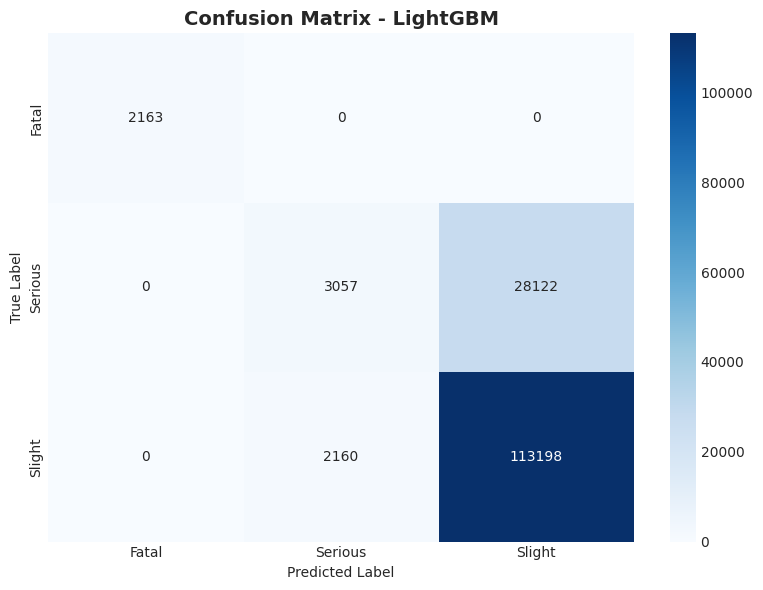

In [56]:
# Confusion Matrix
cm = confusion_matrix(y_test, results[best_model_name]['y_pred'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=severity_labels.values(),
            yticklabels=severity_labels.values())
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


📊 Top 20 Features:
                Feature  Importance
       avg_casualty_age        1288
 casualties_per_vehicle        1030
  dominant_vehicle_type        1002
         avg_driver_age         723
    urban_or_rural_area         620
            speed_limit         533
       pedestrian_count         517
        avg_vehicle_age         418
      male_driver_ratio         398
                   hour         333
     number_of_vehicles         332
                   year         220
   number_of_casualties         215
       light_conditions         177
            fatal_count         176
            day_of_week         155
                  month         151
road_surface_conditions         113
     weather_conditions         108
                 season          61


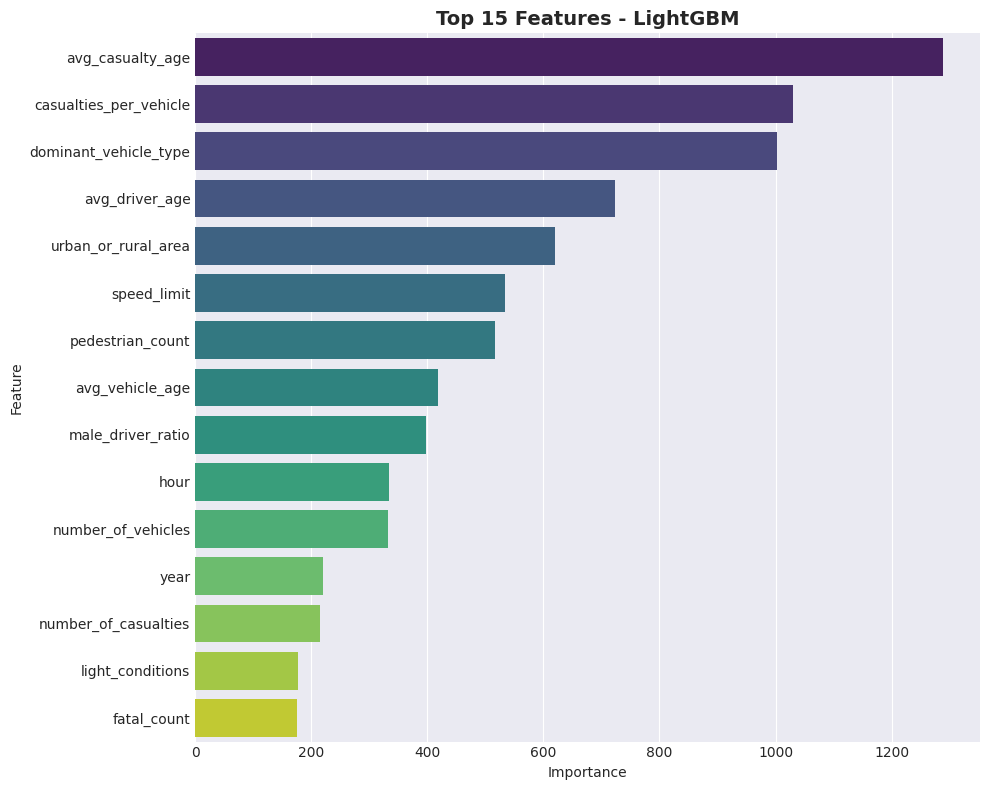

In [57]:
# Feature Importance
if hasattr(best_model, 'feature_importances_'):
    importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Importance': best_model.feature_importances_
    }).sort_values('Importance', ascending=False)
    
    print(f"\n📊 Top 20 Features:")
    print(importance.head(20).to_string(index=False))
    
    plt.figure(figsize=(10, 8))
    sns.barplot(data=importance.head(15), y='Feature', x='Importance', palette='viridis')
    plt.title(f'Top 15 Features - {best_model_name}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

## 💾 11. Model Export

In [58]:
# Save model
joblib.dump(best_model, 'best_accident_model.pkl')
print(f"✅ Model saved: best_accident_model.pkl")

✅ Model saved: best_accident_model.pkl


In [59]:
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(SEVERITY_MAP, 'severity_map.pkl')  # Original UK DfT codes
joblib.dump(severity_labels, 'severity_labels.pkl')  # ML encoded labels
print("✅ Preprocessing saved")

✅ Preprocessing saved


In [60]:
# Save feature names
with open('feature_names.json', 'w') as f:
    json.dump(list(X_train.columns), f)
print("✅ Feature names saved")

✅ Feature names saved


In [61]:
print("\n💡 NOTE: Model uses encoded labels (0,1,2) but exports use original UK DfT codes (1,2,3)")


💡 NOTE: Model uses encoded labels (0,1,2) but exports use original UK DfT codes (1,2,3)


## 🗺️ 12. Geospatial Data for React

In [62]:
print("🗺️ Creating geospatial data for visualization...\n")

def create_risk_grid(coords, grid_size=0.05):
    """Create risk grid for heatmap
    Note: Uses ORIGINAL UK DfT codes (1=Fatal, 2=Serious, 3=Slight)
    """
    lat_bins = np.arange(coords['latitude'].min(), coords['latitude'].max(), grid_size)
    lon_bins = np.arange(coords['longitude'].min(), coords['longitude'].max(), grid_size)
    
    grid = []
    for lat in lat_bins:
        for lon in lon_bins:
            mask = (
                (coords['latitude'] >= lat) & (coords['latitude'] < lat + grid_size) &
                (coords['longitude'] >= lon) & (coords['longitude'] < lon + grid_size)
            )
            cell = coords[mask]
            
            if len(cell) > 0:
                # Use ORIGINAL codes for intuitive interpretation
                total_accidents = int(len(cell))
                avg_severity = float(cell['collision_severity'].mean())  # 1-3 scale
                fatal_count = int((cell['collision_severity'] == 1).sum())
                serious_count = int((cell['collision_severity'] == 2).sum())
                slight_count = int((cell['collision_severity'] == 3).sum())
                
                # Risk score: lower severity code = higher risk (1=Fatal is worst)
                # Invert scale: 4 - avg_severity so Fatal (1) → 3, Slight (3) → 1
                risk_score = float((4 - avg_severity) * np.log1p(total_accidents))
                
                grid.append({
                    'lat': float(lat + grid_size/2),
                    'lon': float(lon + grid_size/2),
                    'total_accidents': total_accidents,
                    'avg_severity': avg_severity,
                    'fatal_count': fatal_count,
                    'serious_count': serious_count,
                    'slight_count': slight_count,
                    'risk_score': risk_score
                })
    return grid

🗺️ Creating geospatial data for visualization...



In [63]:
# Create grid
test_coords = coords_df.loc[X_test.index]
grid_data = create_risk_grid(test_coords)

with open('accident_risk_grid.json', 'w') as f:
    json.dump(grid_data, f)

print(f"✅ Saved {len(grid_data):,} grid cells: accident_risk_grid.json")

✅ Saved 8,154 grid cells: accident_risk_grid.json


In [64]:
# Sample accidents
sample = test_coords.sample(n=min(5000, len(test_coords)), random_state=42)
sample['severity_label'] = sample['collision_severity'].map(SEVERITY_MAP)

sample[['latitude', 'longitude', 'severity_label', 'collision_severity']].to_json(
    'accidents_sample.json', orient='records'
)

print(f"✅ Saved {len(sample):,} samples: accidents_sample.json")

✅ Saved 5,000 samples: accidents_sample.json


In [65]:
# Summary stats (using ORIGINAL UK DfT codes for clarity)
summary = {
    'total_accidents': int(len(df)),
    'date_range': {
        'start': str(df['date'].min().date()),
        'end': str(df['date'].max().date())
    },
    'severity_distribution': {
        'Fatal': int((y_original == 1).sum()),      # UK DfT code 1
        'Serious': int((y_original == 2).sum()),    # UK DfT code 2
        'Slight': int((y_original == 3).sum())      # UK DfT code 3
    },
    'model_performance': {
        'best_model': best_model_name,
        'accuracy': float(results[best_model_name]['accuracy']),
        'f1_score': float(results[best_model_name]['f1_score'])
    },
    'encoding_info': {
        'note': 'Model uses encoded labels (0=Fatal, 1=Serious, 2=Slight)',
        'original_codes': 'UK DfT codes (1=Fatal, 2=Serious, 3=Slight)'
    }
}

with open('summary_statistics.json', 'w') as f:
    json.dump(summary, f, indent=2)

print("✅ Summary saved: summary_statistics.json")

✅ Summary saved: summary_statistics.json


## 🎉 13. Final Summary

In [66]:
print("\n" + "="*70)
print("🎉 PROJECT COMPLETION SUMMARY")
print("="*70)

print(f"""
✅ DATA PROCESSING:
   • Loaded {len(df):,} accidents ({YEAR_FILTER}-2024)
   • Decoded UK DfT numeric codes to readable labels
   • Created 15+ engineered features
   • Final dataset: {df.shape[1]} columns

✅ MACHINE LEARNING:
   • Trained {len(models)} models
   • Best: {best_model_name}
   • Accuracy: {results[best_model_name]['accuracy']:.2%}
   • F1-Score: {results[best_model_name]['f1_score']:.4f}

✅ EXPORTED FILES:
   • best_accident_model.pkl
   • scaler.pkl, severity_map.pkl
   • accident_risk_grid.json ({len(grid_data):,} cells)
   • accidents_sample.json (5,000 samples)
   • summary_statistics.json

🚀 READY FOR REACT VISUALIZATION!
   • Load grid data for heatmap
   • Map risk_score to color intensity
   • Filter by time/weather/severity
""")

print("="*70)


🎉 PROJECT COMPLETION SUMMARY

✅ DATA PROCESSING:
   • Loaded 743,498 accidents (2018-2024)
   • Decoded UK DfT numeric codes to readable labels
   • Created 15+ engineered features
   • Final dataset: 47 columns

✅ MACHINE LEARNING:
   • Trained 3 models
   • Best: LightGBM
   • Accuracy: 79.64%
   • F1-Score: 0.7340

✅ EXPORTED FILES:
   • best_accident_model.pkl
   • scaler.pkl, severity_map.pkl
   • accident_risk_grid.json (8,154 cells)
   • accidents_sample.json (5,000 samples)
   • summary_statistics.json

🚀 READY FOR REACT VISUALIZATION!
   • Load grid data for heatmap
   • Map risk_score to color intensity
   • Filter by time/weather/severity

